In [8]:
import numpy as np
import csv
from lyricsgenius import Genius
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
import re
from sklearn.preprocessing import normalize
import functools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# FORMATTING TO TRANSFORM CSV FILE TO JSON
# GO TO 'TFIDF/SVD PROCESSING'

df = pd.read_csv('0-550.csv')
df2 = pd.read_csv('1074-1699.csv')

In [66]:
artists_0_550 = df['Unnamed: 0']
lyrics_0_550 = df[[str(i) for i in range(10)]].values.tolist()

artists_1074_1699 = df2['Unnamed: 0']
lyrics_1074_1699 = df2[[str(i) for i in range(10)]].values.tolist()

In [67]:
def construct_artist_lyrics_dict(artists, lyrics):
    """ Returns a dictionary mapping artist name to a list of lyrics of their
        top ten songs.
        
    Params:
        artists: list of artist names
        lyrics: corresponding list of list of lyrics
    Returns: dict
    """
    return {artists[i]: lyrics[i] for i in range(len(artists))}

In [68]:
artists_lyrics_0_550 = construct_artist_lyrics_dict(artists_0_550, lyrics_0_550)
artists_lyrics_1074_1699 = construct_artist_lyrics_dict(artists_1074_1699, lyrics_1074_1699)

In [69]:
def concatenate_lyrics(lyrics):
    """ Returns a dictionary mapping artist name to a string containing all lyrics of their
        top ten songs.
        
    Params:
        lyrics: dict mapping artist name to list of lyrics
    Returns: dict
    """
    documents = {}
    for artist in lyrics:
        all_lyrics = ""
        for song in lyrics[artist]:
            if type(song) == 'str':
                all_lyrics += song
        documents[artist] = all_lyrics
    return documents

In [70]:
artist_documents_0_550 = concatenate_lyrics(artists_lyrics_0_550)
artist_documents_1074_1699 = concatenate_lyrics(artists_lyrics_1074_1699)

artist_lyrics_dicts.extend([artist_documents_0_550, artist_documents_1074_1699])

with open('artist_lyrics_0-550.json', 'w') as outfile:
    json.dump(artist_documents_0_550, outfile)
with open('artist_lyrics_1074-1699.json', 'w') as outfile:
    json.dump(artist_documents_1074_1699, outfile)

In [14]:
# TFIDF/SVD PROCESSING
# START PREPROCESSING FOR TFIDF-MATRIX AND SVD

artists_order = pd.read_csv("../removed_dups_new.csv")['artists'].to_list()

artist_lyrics_dicts = []
# path = '../data/processed/ignore/' 
path = ""
for filename in ['artist_lyrics_0-803.json', 'artist_lyrics_804-1606.json',
                 'artist_lyrics_1607-2409.json', 'artist_lyrics_2410-3212.json',
                 'artist_lyrics_3213-4013.json']:
    with open(path + filename) as json_file:
        artist_lyrics_dicts.append(json.load(json_file))

In [16]:
artist_lyrics = {}
for mapping in artist_lyrics_dicts:
    artist_lyrics.update(mapping)
artist_lyrics = {i: artist_lyrics[i] for i in artists_order}

artist_names = list(artists_order)
artist_name_to_index = {artist_names[i] : i for i in range(len(artist_names))}

artist_documents = [artist_lyrics[artist] for artist in artist_names]

In [17]:
def build_vectorizer(max_n_terms=5000, max_prop_docs = 0.8, min_n_docs = 10):
    """Returns a TfidfVectorizer object with certain preprocessing properties.
    
    Params: {max_n_terms: Integer,
             max_prop_docs: Float,
             min_n_docs: Integer}
    Returns: TfidfVectorizer
    """
    return TfidfVectorizer(max_df=max_prop_docs, min_df=min_n_docs, max_features=max_n_terms, stop_words='english')

In [18]:
tfidf_vec = build_vectorizer()
tfidf_mat = tfidf_vec.fit_transform(artist_documents).toarray()
vocab = tfidf_vec.get_feature_names()

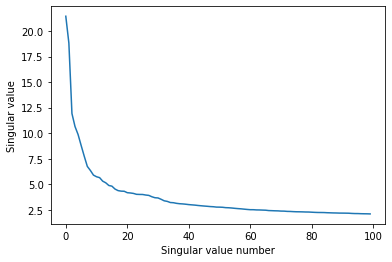

In [19]:
# Plot singular values of the k=100 terms
u, s, v_trans = svds(tfidf_mat, k=100)

plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [20]:
u, s, v = svds(tfidf_mat, k=40)
v = v.transpose()

In [21]:
print(u.shape)
print(v.shape)

(4013, 40)
(5000, 40)


In [22]:
doc_rows = normalize(u, axis=1)
word_rows = v

def closest_projects(project_index_in, k = 5):
    sims = doc_rows.dot(doc_rows[project_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    return [(artist_names[i],sims[i]/sims[asort[0]]) for i in asort[1:]]

In [23]:
# for i in range(40, 50):
#     print(artist_names[i])
#     for title, score in closest_projects(i):
#         print("{}:{:.3f}".format(title[:40], score))
#     print()

index = artist_name_to_index["BTS"]
for title, score in closest_projects(index):
    print("{}:{:.3f}".format(title[:40], score))

My Chemical Romance:0.918
Roxette:0.910
Kaiser Chiefs:0.901
Tujamo:0.895
Gwen Stefani:0.893


In [24]:
tfidf_mat_uncompressed = pd.DataFrame(tfidf_mat, columns = vocab, index = artist_names)
tfidf_mat_compressed = pd.DataFrame(doc_rows, index = artist_names)
words_compressed = pd.DataFrame(word_rows, index = vocab)

In [25]:
tfidf_mat_compressed.to_csv('tfidf_mat_compressed.csv')
tfidf_mat_uncompressed.to_csv('tfidf_mat_uncompressed.csv')
words_compressed.to_csv('words_compressed.csv')

In [1]:
import requests
import json

reviews1 = json.loads(requests.get("https://raw.githubusercontent.com/chynu/cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/master/scripts/ratings_0-803.json").text)
reviews2 = json.loads(requests.get("https://raw.githubusercontent.com/chynu/cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/master/scripts/ratings_804_1606.json").text)
reviews3 = json.loads(requests.get("https://raw.githubusercontent.com/chynu/cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/master/scripts/ratings_1607_2409.json").text)
reviews4 = json.loads(requests.get("https://raw.githubusercontent.com/chynu/cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/master/scripts/ratings_2410_3212.json").text)
reviews5 = json.loads(requests.get("https://raw.githubusercontent.com/chynu/cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/master/scripts/ratings_3213-4013.json").text)
reviews = {**reviews1, **reviews2, **reviews3, **reviews4, **reviews5}

In [2]:
with open("ratings.json", 'w') as file:
    json.dump(reviews, file)

In [3]:
reviews

{'$uicideBoy$': 7.1,
 '03 Greedo': 7.5,
 '10 Years': 6.0,
 '100 gecs': 7.9,
 '112': 7.2,
 '2 Chainz': 7.6,
 '2NE1': 7.3,
 '2Pac': 9.4,
 '311': 7.3,
 '42 Dugg': 7.6,
 '50 Cent': 6.5,
 '6 Dogs': 7.4,
 '6LACK': 7.5,
 '6ix9ine': 3.4,
 '88rising': 6.8,
 '9th Wonder': 7.6,
 'A Great Big World': 8.0,
 'A Perfect Circle': 4.9,
 'A Tribe Called Quest': 9.0,
 'A$AP Ferg': 6.7,
 'A$AP Mob': 6.0,
 'ABBA': 8.3,
 'AC/DC': 8.8,
 'AFI': 5.0,
 'AUGUST 08': 6.8,
 'AURORA': 6.7,
 'Aaliyah': 9.3,
 'Aaron Lewis': 6.5,
 'Ab-Soul': 4.4,
 'Accept': 5.8,
 'Action Bronson': 6.7,
 'Adele': 8.2,
 'Adolescents': 10.0,
 'Adventure Time': 4.8,
 'Aesop Rock': 8.0,
 'Agnes Obel': 7.1,
 'Aim': 6.5,
 'Al Green': 6.7,
 'Alabama': 7.4,
 'Alabama Shakes': 8.6,
 'Alas': 7.7,
 'Albert': 7.3,
 'Alessia Cara': 6.8,
 'Alex Clare': 3.7,
 'Alex G': 6.8,
 'Alice DJ': 7.3,
 'Alice In Chains': 8.0,
 'Alicia Keys': 8.5,
 'Alison Krauss': 5.9,
 'Alkaline Trio': 6.5,
 'All Good Things': 7.0,
 'All That Remains': 7.6,
 'Allie X': 6.8,
 